In [1]:
import sys  
sys.path.append('../models/')
import ExampleModels as em
import torchvision
from torchvision import transforms
import torch

In [2]:
def get_dataset():
    data_dir = '../dataset'
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset.transform = train_transform
    test_dataset.transform = test_transform

    m=len(train_dataset)

    #train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
    batch_size=32

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    #valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
    
    return train_dataset, test_dataset, train_loader, test_loader

train_dataset, test_dataset, train_loader, test_loader = get_dataset()

In [3]:
#TODO eval scaled on abblated data- compare to normal
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim # TODO maybe switch this to torchmetrics to run as batch
from skimage.metrics import mean_squared_error
def eval (ae, max_embed_size, min_p):
    print("running eval")
    n = 10 # TODO parameterize this? - how many embedding sizes to use for eval
    r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))
    encoder = ae.encoder
    decoder = ae.decoder
    device = ae.device
    avg_psnrs=[]
    avg_ssims=[]
    avg_mses=[]

    for i, embed_size in enumerate(r):
        #enumerate test dataset
        print(i, embed_size)
        psnrs = []
        ssims = []
        mses=[]
        for sample_idx in range(len(test_dataset)):
            img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                # ablate embedding
                embedding = encoder(img)
                #create mask
                if embed_size < embedding.shape[1]:
                    embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 
                rec_img  = decoder(embedding)
            ic= img.cpu().squeeze().numpy()
            rc=rec_img.cpu().squeeze().numpy()
            psnrs.append(float(peak_signal_noise_ratio(ic, rc)))
            ssims.append(float(ssim(ic,rc, data_range=1.0)))# 1.0 data range for sigmoid
            mses.append(float(mean_squared_error(ic,rc)))
        avg_psnrs.append(sum(psnrs)/len(psnrs))
        avg_ssims.append(sum(ssims)/len(ssims))
        avg_mses.append(sum(mses)/len(mses))
    
    return r, avg_psnrs, avg_ssims, avg_mses


In [4]:
# train distribution scaled model and evaluate
max_embed_size = 40
min_p = 0.2
ae = em.MNISTAutoEncoder(max_embed_size,use_dr= "sequential",dr_min_p= min_p, scale_output=True)

num_epochs = 20
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(float(train_loss))
    diz_loss['val_loss'].append(float(val_loss))

diz_loss['r'], diz_loss['avg_psnrs'], diz_loss['avg_ssims'], diz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/20 	 train loss 0.047432370483875275 	 val loss 0.026723280549049377
EPOCH 2/20 	 train loss 0.01916230469942093 	 val loss 0.01765054650604725
EPOCH 3/20 	 train loss 0.016154762357473373 	 val loss 0.016755133867263794
EPOCH 4/20 	 train loss 0.014635002240538597 	 val loss 0.015858963131904602
EPOCH 5/20 	 train loss 0.014084492810070515 	 val loss 0.01551929023116827
EPOCH 6/20 	 train loss 0.013481256552040577 	 val loss 0.014472014270722866
EPOCH 7/20 	 train loss 0.012953887693583965 	 val loss 0.013981020078063011
EPOCH 8/20 	 train loss 0.012808042578399181 	 val loss 0.014988775365054607
EPOCH 9/20 	 train loss 0.012441900558769703 	 val loss 0.012693277560174465
EPOCH 10/20 	 train loss 0.012029046192765236 	 val loss 0.012932832352817059
EPOCH 11/20 	 train loss 0.011904751881957054 	 val loss 0.012246482074260712
EPOCH 12/20 	 train loss 0.01161740068346262 	 val loss 0.015382861718535423
EPOCH 13/20 	 train loss 0.011605354957282543 	 val los

In [5]:
# train a normal model and evaluate

#max_embed_size = 40
#min_p = 0.2
ae = em.MNISTAutoEncoder(max_embed_size,use_dr= "sequential",dr_min_p= min_p, scale_output=False)

#num_epochs = 30
niz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    niz_loss['train_loss'].append(float(train_loss))
    niz_loss['val_loss'].append(float(val_loss))
niz_loss['r'], niz_loss['avg_psnrs'], niz_loss['avg_ssims'], niz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/20 	 train loss 0.048755135387182236 	 val loss 0.030066441744565964
EPOCH 2/20 	 train loss 0.02285332791507244 	 val loss 0.021508948877453804
EPOCH 3/20 	 train loss 0.016896303743124008 	 val loss 0.0169703159481287
EPOCH 4/20 	 train loss 0.01520374696701765 	 val loss 0.01531917229294777
EPOCH 5/20 	 train loss 0.014383886940777302 	 val loss 0.014505641534924507
EPOCH 6/20 	 train loss 0.013790220953524113 	 val loss 0.01389216911047697
EPOCH 7/20 	 train loss 0.013300485908985138 	 val loss 0.014052650891244411
EPOCH 8/20 	 train loss 0.012977018021047115 	 val loss 0.013968678191304207
EPOCH 9/20 	 train loss 0.012549338862299919 	 val loss 0.01309144590049982
EPOCH 10/20 	 train loss 0.012429074384272099 	 val loss 0.012601944617927074
EPOCH 11/20 	 train loss 0.012282663956284523 	 val loss 0.013080168515443802
EPOCH 12/20 	 train loss 0.011952150613069534 	 val loss 0.011859184131026268
EPOCH 13/20 	 train loss 0.011696677654981613 	 val loss 0

In [6]:
#no dropout
ae = em.MNISTAutoEncoder(max_embed_size,use_dr= "none",dr_min_p= min_p, scale_output=False)

#num_epochs = 30
iz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    iz_loss['train_loss'].append(float(train_loss))
    iz_loss['val_loss'].append(float(val_loss))
iz_loss['r'], iz_loss['avg_psnrs'], iz_loss['avg_ssims'], iz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/20 	 train loss 0.026344357058405876 	 val loss 0.018017170950770378
EPOCH 2/20 	 train loss 0.00974471028894186 	 val loss 0.013751765713095665
EPOCH 3/20 	 train loss 0.008059895597398281 	 val loss 0.010755643248558044
EPOCH 4/20 	 train loss 0.00717015378177166 	 val loss 0.009336382150650024
EPOCH 5/20 	 train loss 0.0065903146751224995 	 val loss 0.009309004992246628
EPOCH 6/20 	 train loss 0.0062136403284966946 	 val loss 0.009393442422151566
EPOCH 7/20 	 train loss 0.005943539552390575 	 val loss 0.0094643235206604
EPOCH 8/20 	 train loss 0.005733508616685867 	 val loss 0.00935366004705429
EPOCH 9/20 	 train loss 0.0055608926340937614 	 val loss 0.00939712394028902
EPOCH 10/20 	 train loss 0.005422485526651144 	 val loss 0.00965182390064001
EPOCH 11/20 	 train loss 0.005289312917739153 	 val loss 0.009368172846734524
EPOCH 12/20 	 train loss 0.005168610718101263 	 val loss 0.008944233879446983
EPOCH 13/20 	 train loss 0.005066756624728441 	 val los

In [7]:
#traditional dropout
ae = em.MNISTAutoEncoder(max_embed_size,use_dr= "standard",dr_min_p= min_p, scale_output=False)

#num_epochs = 30
tiz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    tiz_loss['train_loss'].append(float(train_loss))
    tiz_loss['val_loss'].append(float(val_loss))
tiz_loss['r'], tiz_loss['avg_psnrs'], tiz_loss['avg_ssims'], tiz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/20 	 train loss 0.06362666189670563 	 val loss 0.06412167847156525
EPOCH 2/20 	 train loss 0.04899042844772339 	 val loss 0.06751885265111923
EPOCH 3/20 	 train loss 0.045197635889053345 	 val loss 0.0683758482336998
EPOCH 4/20 	 train loss 0.04369911178946495 	 val loss 0.07034818828105927
EPOCH 5/20 	 train loss 0.042745597660541534 	 val loss 0.07214392721652985
EPOCH 6/20 	 train loss 0.041943058371543884 	 val loss 0.0753193125128746
EPOCH 7/20 	 train loss 0.04132426902651787 	 val loss 0.07487936317920685
EPOCH 8/20 	 train loss 0.04085250571370125 	 val loss 0.0768708810210228
EPOCH 9/20 	 train loss 0.040509749203920364 	 val loss 0.07726656645536423
EPOCH 10/20 	 train loss 0.04005396366119385 	 val loss 0.0780823677778244
EPOCH 11/20 	 train loss 0.03969665616750717 	 val loss 0.0797385573387146
EPOCH 12/20 	 train loss 0.039374612271785736 	 val loss 0.07972235977649689
EPOCH 13/20 	 train loss 0.03912746161222458 	 val loss 0.08144164830446243

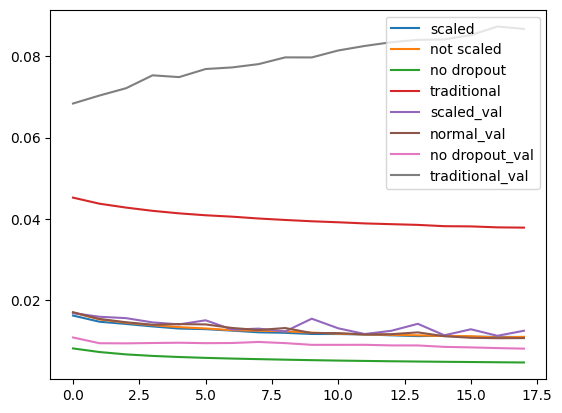

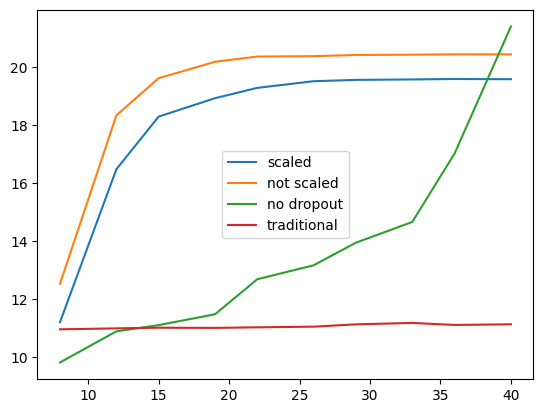

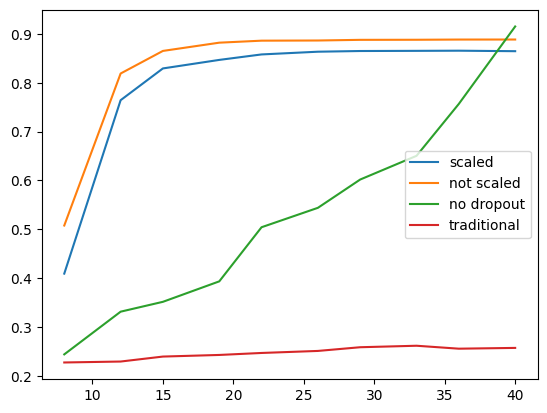

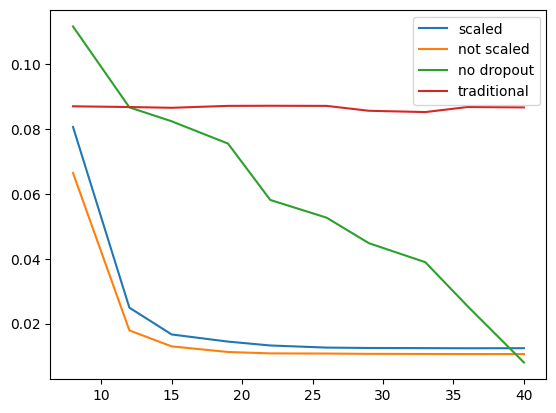

In [10]:
import matplotlib.pyplot as plt
start = 2
plt.plot(diz_loss['train_loss'][start:],label='scaled')
plt.plot(niz_loss['train_loss'][start:],label='not scaled')
plt.plot(iz_loss['train_loss'][start:],label='no dropout')
plt.plot(tiz_loss['train_loss'][start:],label='traditional')
plt.plot(diz_loss['val_loss'][start:],label='scaled_val')
plt.plot(niz_loss['val_loss'][start:],label='normal_val')
plt.plot(iz_loss['val_loss'][start:],label='no dropout_val')
plt.plot(tiz_loss['val_loss'][start:],label='traditional_val')
plt.legend()
plt.show()

#reconstruction error
plt.plot(diz_loss['r'], diz_loss['avg_psnrs'],label='scaled')
plt.plot(niz_loss['r'], niz_loss['avg_psnrs'],label='not scaled')
plt.plot(iz_loss['r'], iz_loss['avg_psnrs'],label='no dropout')
plt.plot(tiz_loss['r'], tiz_loss['avg_psnrs'],label='traditional')
plt.legend()
plt.show()

plt.plot(diz_loss['r'], diz_loss['avg_ssims'],label='scaled')
plt.plot(niz_loss['r'], niz_loss['avg_ssims'],label='not scaled')
plt.plot(iz_loss['r'], iz_loss['avg_ssims'],label='no dropout')
plt.plot(tiz_loss['r'], tiz_loss['avg_ssims'],label='traditional')
plt.legend()
plt.show()

plt.plot(diz_loss['r'], diz_loss['avg_mses'],label='scaled')
plt.plot(niz_loss['r'], niz_loss['avg_mses'],label='not scaled')
plt.plot(iz_loss['r'], iz_loss['avg_mses'],label='no dropout')
plt.plot(tiz_loss['r'], tiz_loss['avg_mses'],label='traditional')
plt.legend()
plt.show()

In [ ]:
# TODO eval a normal autoencoder with normal dropout
# this is done but there might be an error with the dropout - its not performing as expected
# the dropout percent might be way to high

# todo eval with random abblation on dropout